#Aviation Safety Data Analysis

In [69]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
from os import path
from PIL import Image
from matplotlib import rcParams
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

sb.set() # set the default Seaborn style for graphics


In [6]:
import urllib.request
import pickle

aData = pd.read_csv('AviationData.csv')
aData.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.Flight,Air.Carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Report.Status,Publication.Date
0,20200102X82407,Accident,WPR20CA055,12/31/2019,"Elk, CA",United States,39.128611,-123.715833,LLR,Little River,...,Personal,NaN,NaN,NaN,NaN,1.0,VMC,TAKEOFF,Factual,13/01/2020
1,20191231X83852,Accident,CEN20FA049,12/31/2019,"OLATHE, KS",United States,38.846111,-94.736111,OJC,Johnson County Executive,...,Personal,NaN,2.0,NaN,NaN,NaN,VMC,TAKEOFF,Preliminary,8/1/2020
2,20200102X54844,Accident,ANC20CA011,12/31/2019,"Fairbanks, AK",United States,64.666945,-148.133334,NaN,NaN,...,Personal,NaN,NaN,NaN,NaN,2.0,NaN,NaN,Preliminary,2/1/2020
3,20191230X91852,Accident,CEN20CA048,12/30/2019,"GRANBURY, TX",United States,32.365556,-97.645000,NaN,NaN,...,Personal,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Preliminary,31/12/2019
4,20191228X62945,NaN,WPR20CA053,12/28/2019,"Missoula, MT",United States,NaN,NaN,MSO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Preliminary,3/1/2020


#Data Clean-up and Handling

### Eliminate non-useful columns in dataframe

In [7]:
drop = ['Accident.Number', 'Registration.Number'
    , 'Schedule', 'FAR.Description', 'Air.Carrier', 'Report.Status', 'Publication.Date']
sort_data = pd.DataFrame(aData)
sort_data.drop(columns=drop, inplace=True)
sort_data.head()

,Event.Id,Investigation.Type,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,...,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.Flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight
0,20200102X82407,Accident,12/31/2019,"Elk, CA",United States,39.128611,-123.715833,LLR,Little River,Non-Fatal,...,No,1.0,Reciprocating,Personal,NaN,NaN,NaN,1.0,VMC,TAKEOFF
1,20191231X83852,Accident,12/31/2019,"OLATHE, KS",United States,38.846111,-94.736111,OJC,Johnson County Executive,Fatal(2),...,No,1.0,Reciprocating,Personal,2.0,NaN,NaN,NaN,VMC,TAKEOFF
2,20200102X54844,Accident,12/31/2019,"Fairbanks, AK",United States,64.666945,-148.133334,NaN,NaN,Non-Fatal,...,No,1.0,NaN,Personal,NaN,NaN,NaN,2.0,NaN,NaN
3,20191230X91852,Accident,12/30/2019,"GRANBURY, TX",United States,32.365556,-97.645000,NaN,NaN,Non-Fatal,...,Yes,NaN,NaN,Personal,NaN,NaN,NaN,1.0,NaN,NaN
4,20191228X62945,NaN,12/28/2019,"Missoula, MT",United States,NaN,NaN,MSO,NaN,Unavailable,...,No,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###Remove non-US rows

In [8]:
sort_data = sort_data[sort_data.Country == 'United States']

### Split date into year, month, day

In [9]:
sort_data['month'], sort_data['day'], sort_data['year'] = zip(*sort_data['Event.Date'].map(lambda x: str(x).split('/')))

In [10]:
sort_data.head()

,Event.Id,Investigation.Type,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,...,Purpose.of.Flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,month,day,year
0,20200102X82407,Accident,12/31/2019,"Elk, CA",United States,39.128611,-123.715833,LLR,Little River,Non-Fatal,...,Personal,NaN,NaN,NaN,1.0,VMC,TAKEOFF,12,31,2019
1,20191231X83852,Accident,12/31/2019,"OLATHE, KS",United States,38.846111,-94.736111,OJC,Johnson County Executive,Fatal(2),...,Personal,2.0,NaN,NaN,NaN,VMC,TAKEOFF,12,31,2019
2,20200102X54844,Accident,12/31/2019,"Fairbanks, AK",United States,64.666945,-148.133334,NaN,NaN,Non-Fatal,...,Personal,NaN,NaN,NaN,2.0,NaN,NaN,12,31,2019
3,20191230X91852,Accident,12/30/2019,"GRANBURY, TX",United States,32.365556,-97.645000,NaN,NaN,Non-Fatal,...,Personal,NaN,NaN,NaN,1.0,NaN,NaN,12,30,2019
4,20191228X62945,NaN,12/28/2019,"Missoula, MT",United States,NaN,NaN,MSO,NaN,Unavailable,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,28,2019


In [11]:
sort_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78849 entries, 0 to 84261
Data columns (total 27 columns):
Event.Id                  78849 non-null object
Investigation.Type        78844 non-null object
Event.Date                78849 non-null object
Location                  78820 non-null object
Country                   78849 non-null object
Latitude                  28422 non-null float64
Longitude                 28412 non-null float64
Airport.Code              46839 non-null object
Airport.Name              49427 non-null object
Injury.Severity           78849 non-null object
Aircraft.Damage           76937 non-null object
Aircraft.Category         24580 non-null object
Make                      78826 non-null object
Model                     78810 non-null object
Amateur.Built             78748 non-null object
Number.of.Engines         77057 non-null float64
Engine.Type               77477 non-null object
Purpose.of.Flight         76569 non-null object
Total.Fatal.Injuries    

In [12]:
sort_data["year"]= pd.to_numeric(sort_data["year"])
sort_data["month"]= pd.to_numeric(sort_data["month"])
sort_data["day"]= pd.to_numeric(sort_data["day"])
sort_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78849 entries, 0 to 84261
Data columns (total 27 columns):
Event.Id                  78849 non-null object
Investigation.Type        78844 non-null object
Event.Date                78849 non-null object
Location                  78820 non-null object
Country                   78849 non-null object
Latitude                  28422 non-null float64
Longitude                 28412 non-null float64
Airport.Code              46839 non-null object
Airport.Name              49427 non-null object
Injury.Severity           78849 non-null object
Aircraft.Damage           76937 non-null object
Aircraft.Category         24580 non-null object
Make                      78826 non-null object
Model                     78810 non-null object
Amateur.Built             78748 non-null object
Number.of.Engines         77057 non-null float64
Engine.Type               77477 non-null object
Purpose.of.Flight         76569 non-null object
Total.Fatal.Injuries    

## Sort injury severity
### Non-fatal, Fatal(..), Unavailable, Incident
### Non-fatal, Fatal, Unknown, Incident
### Fatal(7) is the number of fatal injuries which can be found in Total.Fatal.Injuries

In [13]:
fatal_stat= []
deaths = []
for x in range(len(sort_data)):
    if str(sort_data.iloc[x]['Injury.Severity']) == 'Non-Fatal':
        fatal_stat.append("Non-Fatal")
        deaths.append(0)
    elif str(sort_data.iloc[x]['Injury.Severity']) == 'Unavailable':
        fatal_stat.append("Unknown")
        deaths.append(0)
    elif str(sort_data.iloc[x]['Injury.Severity']) == 'Incident':
        fatal_stat.append("Non-Fatal")
        deaths.append(0)
    else:
        fatal_stat.append("Fatal")
        str_d = sort_data.iloc[x]['Injury.Severity']
        str_d = str_d.replace(')', '(')
        num = str_d.split('(')
        deaths.append(int(num[1]))


sort_data['Fatal_status']= fatal_stat
sort_data['Deaths']= deaths

sort_data = sort_data[sort_data.Fatal_status != 'Unknown']

In [14]:
sort_data.head()

,Event.Id,Investigation.Type,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,...,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,month,day,year,Fatal_status,Deaths
0,20200102X82407,Accident,12/31/2019,"Elk, CA",United States,39.128611,-123.715833,LLR,Little River,Non-Fatal,...,NaN,NaN,1.0,VMC,TAKEOFF,12,31,2019,Non-Fatal,0
1,20191231X83852,Accident,12/31/2019,"OLATHE, KS",United States,38.846111,-94.736111,OJC,Johnson County Executive,Fatal(2),...,NaN,NaN,NaN,VMC,TAKEOFF,12,31,2019,Fatal,2
2,20200102X54844,Accident,12/31/2019,"Fairbanks, AK",United States,64.666945,-148.133334,NaN,NaN,Non-Fatal,...,NaN,NaN,2.0,NaN,NaN,12,31,2019,Non-Fatal,0
3,20191230X91852,Accident,12/30/2019,"GRANBURY, TX",United States,32.365556,-97.645000,NaN,NaN,Non-Fatal,...,NaN,NaN,1.0,NaN,NaN,12,30,2019,Non-Fatal,0
5,20191228X23853,Accident,12/28/2019,"LAFAYETTE, LA",United States,30.176111,-92.007500,LFT,Lafayette Regional Apt,Fatal(5),...,2.0,2.0,NaN,IMC,TAKEOFF,12,28,2019,Fatal,5


##Number of latitude and longitude does not match
### Reorganise to match for map

In [15]:
map_lat=[]
map_long=[]
for x in range(len(sort_data)):
    if pd.isnull(sort_data.iloc[x]['Latitude']) == False and pd.isnull(sort_data.iloc[x]['Longitude']) == False:
        map_lat.append(sort_data.iloc[x]['Latitude'])
        map_long.append(sort_data.iloc[x]['Longitude'])
    else:
        map_lat.append(np.NaN)
        map_long.append(np.NaN)
sort_data['Map_latitude'] = map_lat
sort_data['Map_longitude'] = map_long

In [16]:
sort_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78741 entries, 0 to 84261
Data columns (total 31 columns):
Event.Id                  78741 non-null object
Investigation.Type        78740 non-null object
Event.Date                78741 non-null object
Location                  78712 non-null object
Country                   78741 non-null object
Latitude                  28379 non-null float64
Longitude                 28369 non-null float64
Airport.Code              46777 non-null object
Airport.Name              49388 non-null object
Injury.Severity           78741 non-null object
Aircraft.Damage           76854 non-null object
Aircraft.Category         24521 non-null object
Make                      78718 non-null object
Model                     78702 non-null object
Amateur.Built             78641 non-null object
Number.of.Engines         76988 non-null float64
Engine.Type               77449 non-null object
Purpose.of.Flight         76494 non-null object
Total.Fatal.Injuries    

In [17]:
sort_data.fillna({'Map_latitude': 'Nan', 'Map_longitude': 'Nan', 'Total.Fatal.Injuries': 'Nan', 'Total.Serious.Injuries': 
                  'Nan', 'Total.Minor.Injuries': 'Nan', 'Total.Uninjured': 'Nan', 'Latitude': 'Nan', 'Longitude': 'Nan'
                 , 'Airport.Code': 'Nan', 'Aircraft.Category': 'Nan', 'Aircraft.Name': 'Nan'}, inplace=True)

In [18]:
sort_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78741 entries, 0 to 84261
Data columns (total 31 columns):
Event.Id                  78741 non-null object
Investigation.Type        78740 non-null object
Event.Date                78741 non-null object
Location                  78712 non-null object
Country                   78741 non-null object
Latitude                  78741 non-null object
Longitude                 78741 non-null object
Airport.Code              78741 non-null object
Airport.Name              49388 non-null object
Injury.Severity           78741 non-null object
Aircraft.Damage           76854 non-null object
Aircraft.Category         78741 non-null object
Make                      78718 non-null object
Model                     78702 non-null object
Amateur.Built             78641 non-null object
Number.of.Engines         76988 non-null float64
Engine.Type               77449 non-null object
Purpose.of.Flight         76494 non-null object
Total.Fatal.Injuries      

In [19]:
clean_df = sort_data.dropna()
print(clean_df)

             Event.Id Investigation.Type  Event.Date             Location  \
0      20200102X82407           Accident  12/31/2019              Elk, CA   
1      20191231X83852           Accident  12/31/2019           OLATHE, KS   
5      20191228X23853           Accident  12/28/2019        LAFAYETTE, LA   
14     20191224X43854           Accident  12/18/2019         Harrison, OH   
21     20191213X05304           Accident  12/12/2019         Carlsbad, CA   
22     20191211X12602           Accident  12/11/2019          Phoenix, AZ   
24     20191209X51617           Accident   12/8/2019   Willow Springs, MO   
28     20191209X03550           Accident   12/6/2019    Spring Branch, TX   
30     20191205X42835           Accident   12/4/2019     Baldwin City, KS   
34     20191202X50119           Accident   12/2/2019       Vero Beach, FL   
35     20191202X00729           Accident   12/1/2019       Union City, TN   
36     20191201X05432           Accident   12/1/2019      San Antonio, TX   

In [20]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44872 entries, 0 to 84254
Data columns (total 31 columns):
Event.Id                  44872 non-null object
Investigation.Type        44872 non-null object
Event.Date                44872 non-null object
Location                  44872 non-null object
Country                   44872 non-null object
Latitude                  44872 non-null object
Longitude                 44872 non-null object
Airport.Code              44872 non-null object
Airport.Name              44872 non-null object
Injury.Severity           44872 non-null object
Aircraft.Damage           44872 non-null object
Aircraft.Category         44872 non-null object
Make                      44872 non-null object
Model                     44872 non-null object
Amateur.Built             44872 non-null object
Number.of.Engines         44872 non-null float64
Engine.Type               44872 non-null object
Purpose.of.Flight         44872 non-null object
Total.Fatal.Injuries      

In [21]:
clean_df = clean_df.replace('Nan', np.nan)

In [22]:
clean_df[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Uninjured', 'Total.Minor.Injuries']] = clean_df[['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Uninjured', 'Total.Minor.Injuries']].replace(np.nan, 0)

###Rename column headings

In [23]:
clean_df.rename(columns = {'Event.Id':'Event_id'}, inplace = True)
clean_df.rename(columns = {'Investigation.Type':'Investigation_type'}, inplace = True)
clean_df.rename(columns = {'Event.Date':'Event_date'}, inplace = True)
clean_df.rename(columns = {'Airport.Code':'Airport_code'}, inplace = True)
clean_df.rename(columns = {'Injury.Severity':'Injury_severity'}, inplace = True)
clean_df.rename(columns = {'Aircraft.Damage':'Aircraft_damage'}, inplace = True)
clean_df.rename(columns = {'Aircraft.Category':'Aircraft_category'}, inplace = True)
clean_df.rename(columns = {'Amateur.Built':'Amateur_built'}, inplace = True)
clean_df.rename(columns = {'Number.of.Engines':'Number_of_engines'}, inplace = True)
clean_df.rename(columns = {'Engine.Type':'Engine_type'}, inplace = True)
clean_df.rename(columns = {'Purpose.of.Flight':'Purpose_of_flight'}, inplace = True)
clean_df.rename(columns = {'Total.Fatal.Injuries':'Total_fatal_injuries'}, inplace = True)
clean_df.rename(columns = {'Total.Serious.Injuries':'Total_serious_injuries'}, inplace = True)
clean_df.rename(columns = {'Total.Minor.Injuries':'Total_minor_injuries'}, inplace = True)
clean_df.rename(columns = {'Total.Uninjured':'Total_uninjured'}, inplace = True)
clean_df.rename(columns = {'Weather.Condition':'Weather_condition'}, inplace = True)
clean_df.rename(columns = {'Broad.Phase.of.Flight':'Broad_phase_of_flight'}, inplace = True)
clean_df.rename(columns = {'Airport.Name':'Airport_name'}, inplace = True)

clean_df.head()

,Event_id,Investigation_type,Event_date,Location,Country,Latitude,Longitude,Airport_code,Airport_name,Injury_severity,...,Total_uninjured,Weather_condition,Broad_phase_of_flight,month,day,year,Fatal_status,Deaths,Map_latitude,Map_longitude
0,20200102X82407,Accident,12/31/2019,"Elk, CA",United States,39.128611,-123.715833,LLR,Little River,Non-Fatal,...,1.0,VMC,TAKEOFF,12,31,2019,Non-Fatal,0,39.128611,-123.715833
1,20191231X83852,Accident,12/31/2019,"OLATHE, KS",United States,38.846111,-94.736111,OJC,Johnson County Executive,Fatal(2),...,0.0,VMC,TAKEOFF,12,31,2019,Fatal,2,38.846111,-94.736111
5,20191228X23853,Accident,12/28/2019,"LAFAYETTE, LA",United States,30.176111,-92.007500,LFT,Lafayette Regional Apt,Fatal(5),...,0.0,IMC,TAKEOFF,12,28,2019,Fatal,5,30.176111,-92.007500
14,20191224X43854,Accident,12/18/2019,"Harrison, OH",United States,39.259167,-84.774445,I67,Cincinnati West,Non-Fatal,...,2.0,VMC,LANDING,12,18,2019,Non-Fatal,0,39.259167,-84.774445
21,20191213X05304,Accident,12/12/2019,"Carlsbad, CA",United States,33.146389,-117.333611,KCRQ,McCellan,Non-Fatal,...,2.0,VMC,CRUISE,12,12,2019,Non-Fatal,0,33.146389,-117.333611


###Make count of non-fatal equal to count of fatal

In [24]:
fatal_total_df = clean_df[clean_df.Fatal_status == 'Fatal']
non_fatal_df = clean_df[clean_df.Fatal_status == 'Non-Fatal']

non_fatal_df = non_fatal_df.sample(n = len(fatal_total_df)) 
non_fatal_df.head()

clean_df = pd.concat([non_fatal_df, fatal_total_df], ignore_index=True)



###For plotting map.

In [25]:
map_data = pd.DataFrame(clean_df[['Map_latitude', 'Map_longitude', 'Location', 'Fatal_status']])
map_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12232 entries, 0 to 12231
Data columns (total 4 columns):
Map_latitude     4655 non-null float64
Map_longitude    4655 non-null float64
Location         12232 non-null object
Fatal_status     12232 non-null object
dtypes: float64(2), object(2)
memory usage: 382.3+ KB


In [26]:
map_data =  map_data.dropna()
map_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4655 entries, 0 to 12193
Data columns (total 4 columns):
Map_latitude     4655 non-null float64
Map_longitude    4655 non-null float64
Location         4655 non-null object
Fatal_status     4655 non-null object
dtypes: float64(2), object(2)
memory usage: 181.8+ KB


###Variables with no values

In [27]:
aData.isnull().sum()

Event.Id                      0
Investigation.Type            5
Accident.Number               0
Event.Date                    0
Location                     77
Country                     507
Latitude                  54099
Longitude                 54108
Airport.Code              36539
Airport.Name              33823
Injury.Severity               0
Aircraft.Damage            2709
Aircraft.Category         56754
Registration.Number        3850
Make                         70
Model                        99
Amateur.Built               609
Number.of.Engines          5034
Engine.Type                4256
FAR.Description           57056
Schedule                  72419
Purpose.of.Flight          4880
Air.Carrier               80093
Total.Fatal.Injuries      27203
Total.Serious.Injuries    29878
Total.Minor.Injuries      28670
Total.Uninjured           14589
Weather.Condition          3103
Broad.Phase.of.Flight      6608
Report.Status                 0
Publication.Date          14315
dtype: i

###Check the variables and their types

In [28]:
print(clean_df.dtypes)

Event_id                   object
Investigation_type         object
Event_date                 object
Location                   object
Country                    object
Latitude                  float64
Longitude                 float64
Airport_code               object
Airport_name               object
Injury_severity            object
Aircraft_damage            object
Aircraft_category          object
Make                       object
Model                      object
Amateur_built              object
Number_of_engines         float64
Engine_type                object
Purpose_of_flight          object
Total_fatal_injuries      float64
Total_serious_injuries    float64
Total_minor_injuries      float64
Total_uninjured           float64
Weather_condition          object
Broad_phase_of_flight      object
month                       int64
day                         int64
year                        int64
Fatal_status               object
Deaths                      int64
Map_latitude  

In [29]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12232 entries, 0 to 12231
Data columns (total 31 columns):
Event_id                  12232 non-null object
Investigation_type        12232 non-null object
Event_date                12232 non-null object
Location                  12232 non-null object
Country                   12232 non-null object
Latitude                  4655 non-null float64
Longitude                 4655 non-null float64
Airport_code              11435 non-null object
Airport_name              12232 non-null object
Injury_severity           12232 non-null object
Aircraft_damage           12232 non-null object
Aircraft_category         3635 non-null object
Make                      12232 non-null object
Model                     12232 non-null object
Amateur_built             12232 non-null object
Number_of_engines         12232 non-null float64
Engine_type               12232 non-null object
Purpose_of_flight         12232 non-null object
Total_fatal_injuries      1

#Basic Data Visualization

###Count of fatal accidents by year

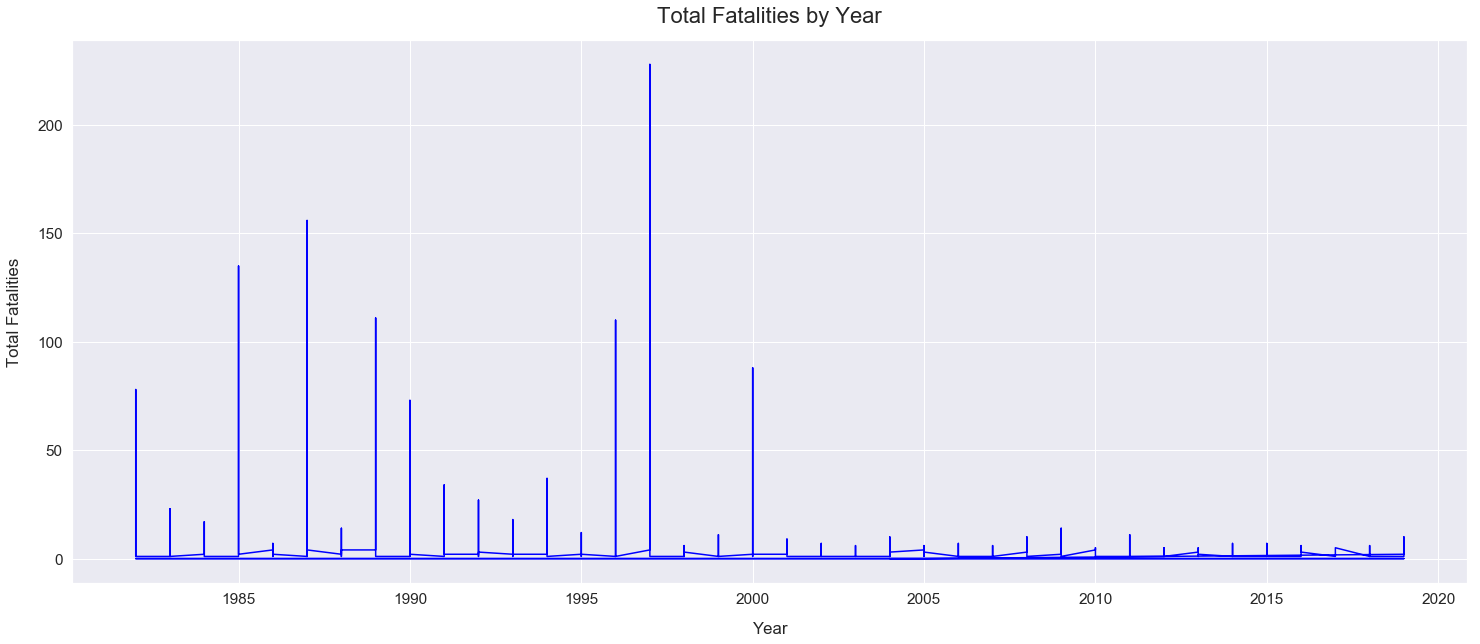

In [30]:
##need to clean up data so that will have distinct lines
sb.set(font_scale=1.4)
clean_df.set_index('year')['Total_fatal_injuries'].plot(figsize=(25, 10), linewidth=1.5, color='blue')
plt.xlabel("Year", labelpad=15)
plt.ylabel("Total Fatalities", labelpad=15)
plt.title("Total Fatalities by Year", y=1.02, fontsize=22);


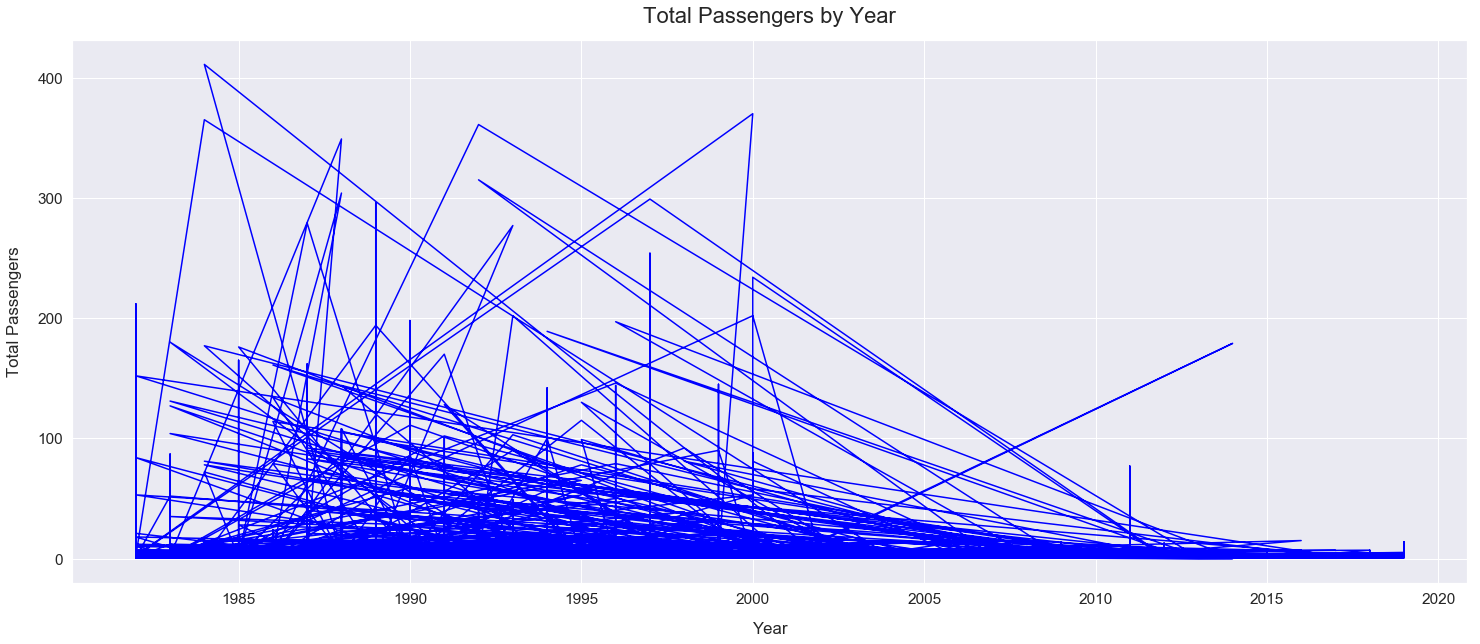

In [31]:
clean_df['Total_passengers'] = clean_df['Total_serious_injuries'] + clean_df['Total_minor_injuries'] + clean_df['Total_fatal_injuries'] + clean_df['Total_uninjured']
sb.set(font_scale=1.4)
clean_df.set_index('year')['Total_passengers'].plot(figsize=(25, 10), linewidth=1.5, color='blue')
plt.xlabel("Year", labelpad=15)
plt.ylabel("Total Passengers", labelpad=15)
plt.title("Total Passengers by Year", y=1.02, fontsize=22);

#Uni-variate Exploratory Analysis

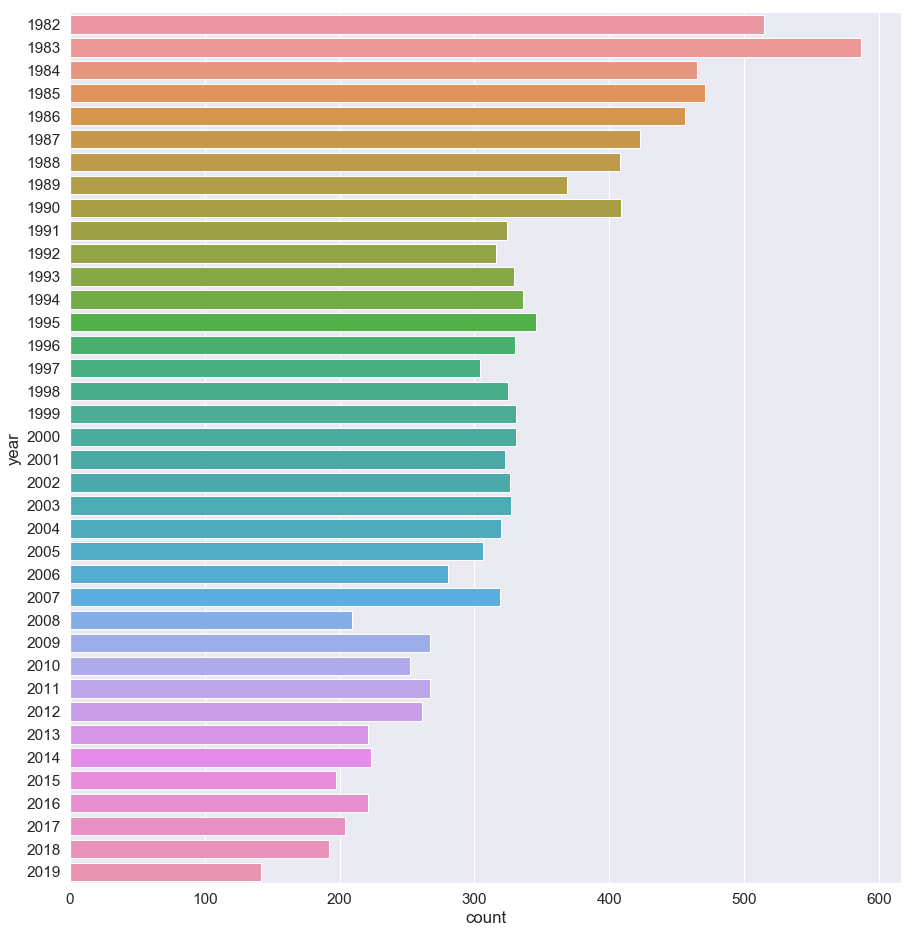

In [32]:
#Distribution for year
sb.catplot(y = "year", data = clean_df, kind = "count", height = 13,  orient="v")

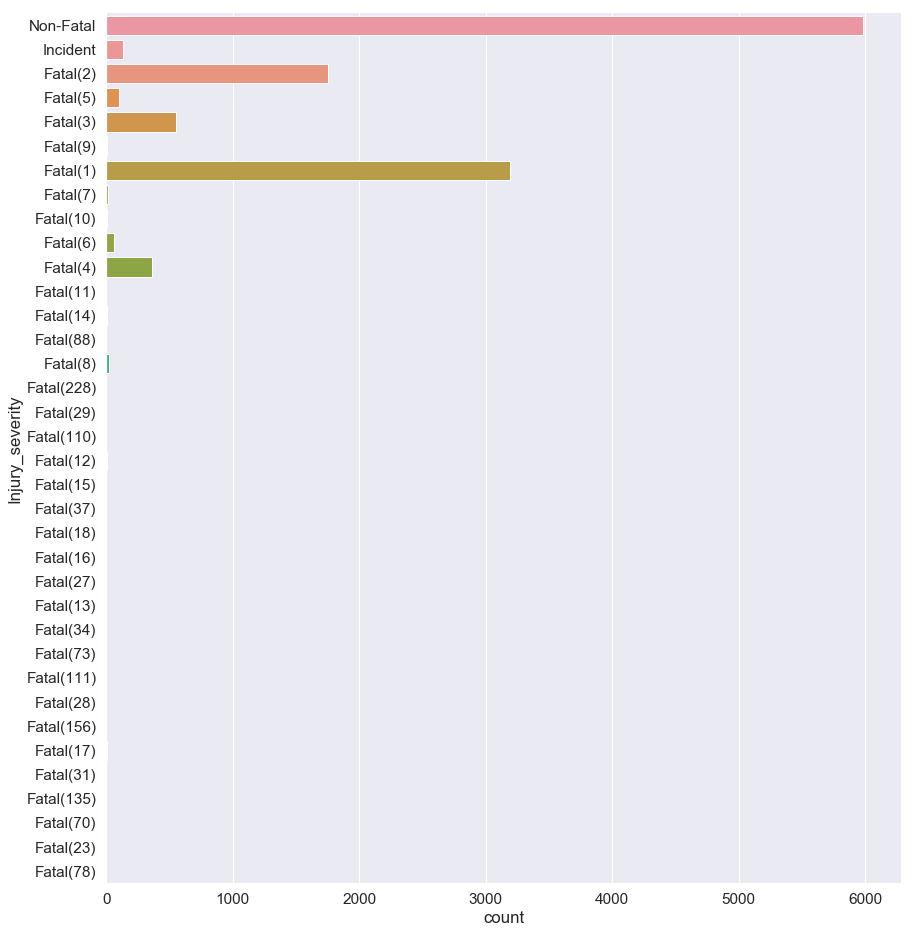

In [33]:
#Distribution for Injury severity
sb.catplot(y = "Injury_severity", data = clean_df, kind = "count", height = 13)

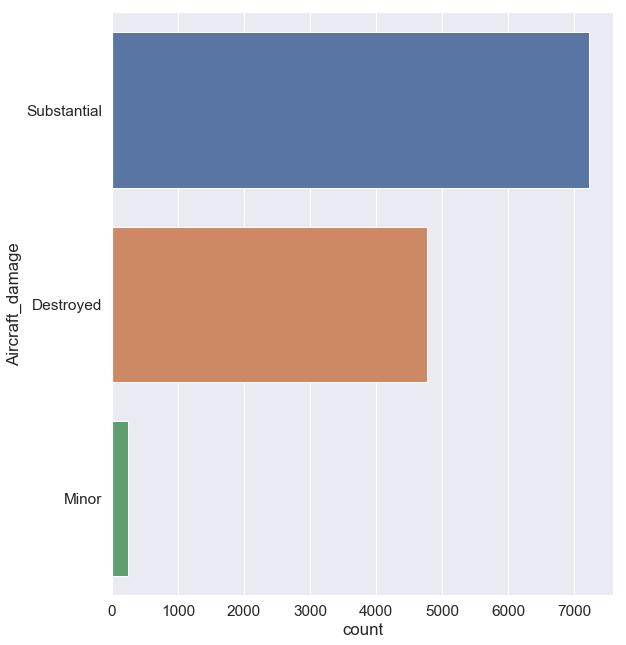

In [34]:
#Distribution for Aircraft damage
sb.catplot(y = "Aircraft_damage", data = clean_df, kind = "count", height = 9)

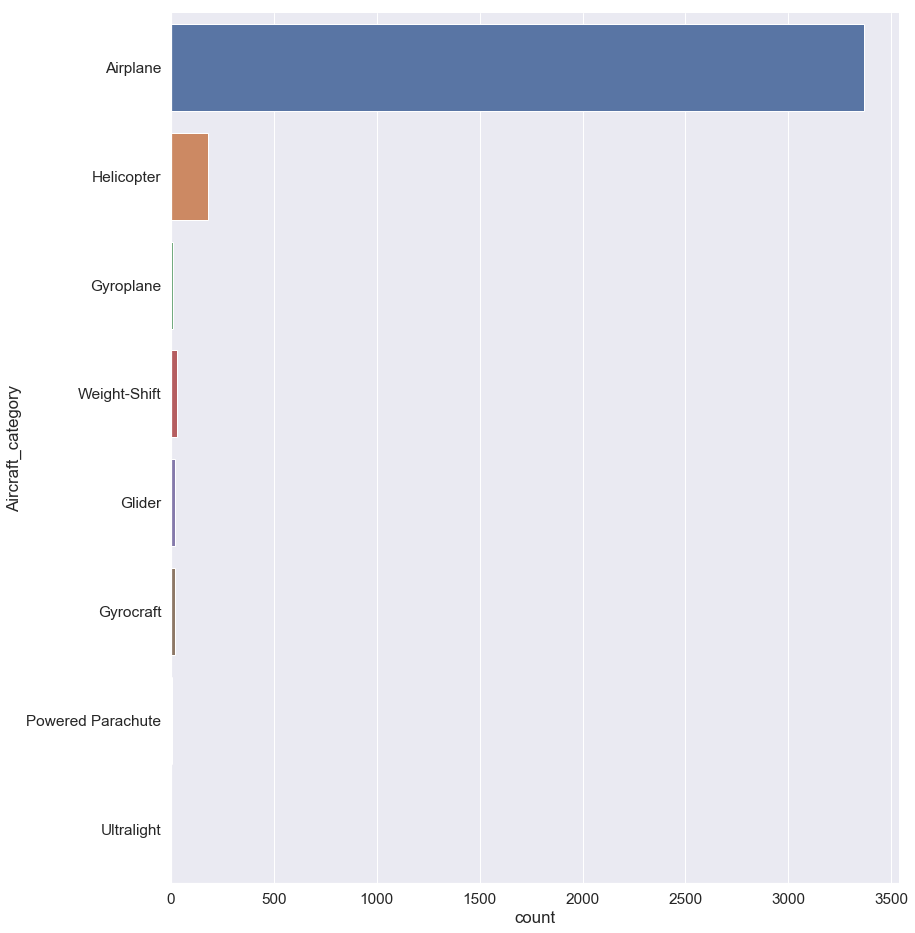

In [35]:
#Distribution for Aircraft category
sb.catplot(y = "Aircraft_category", data = clean_df, kind = "count", height = 13)

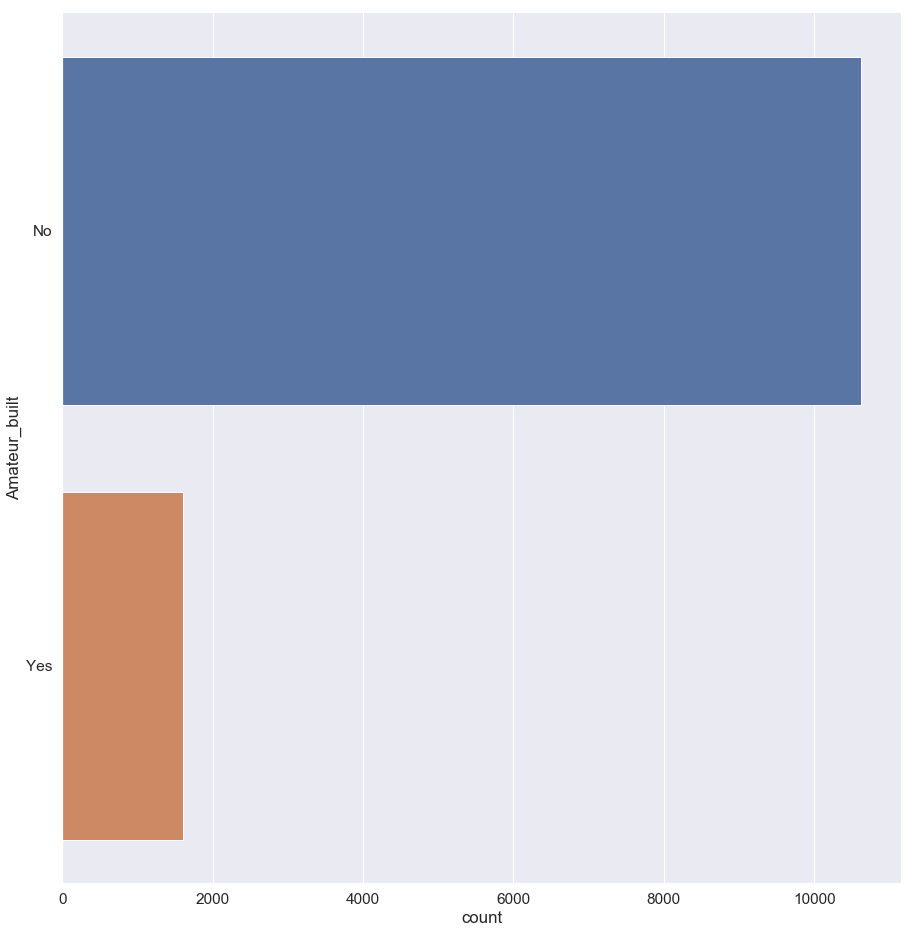

In [36]:
#Distribution for Amateur built
sb.catplot(y = "Amateur_built", data = clean_df, kind = "count", height = 13)

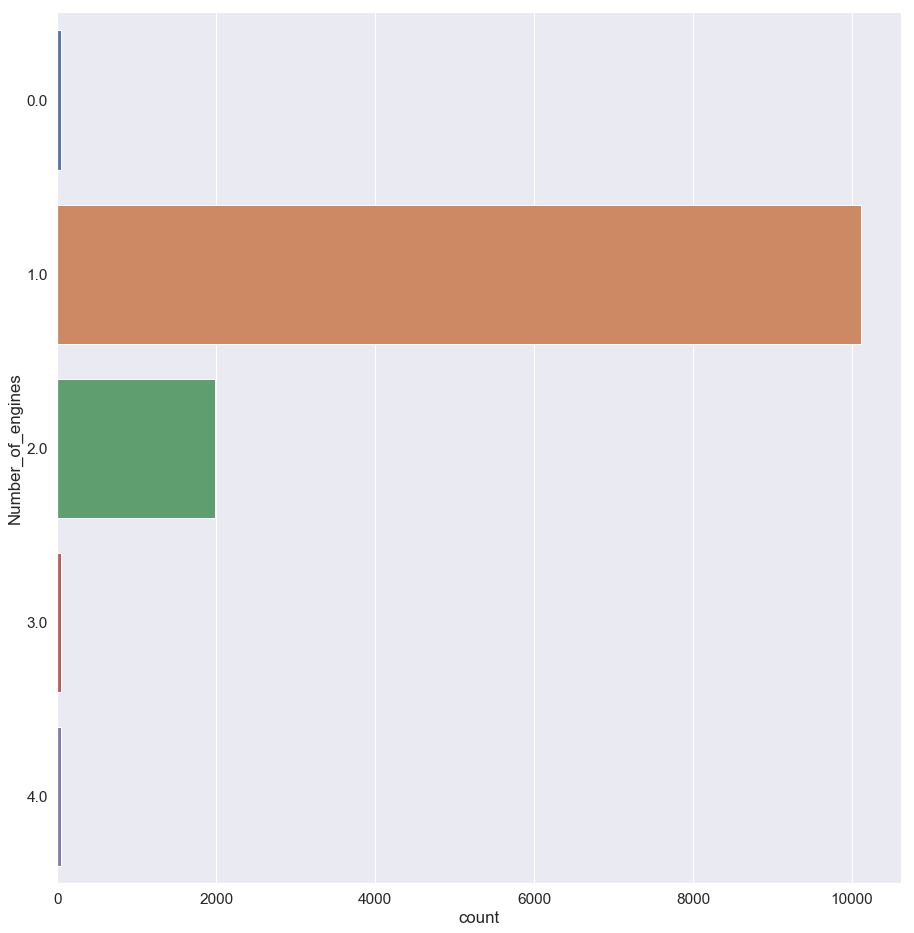

In [37]:
#Distribution for Number of engines
sb.catplot(y = "Number_of_engines", data = clean_df, kind = "count", height = 13)

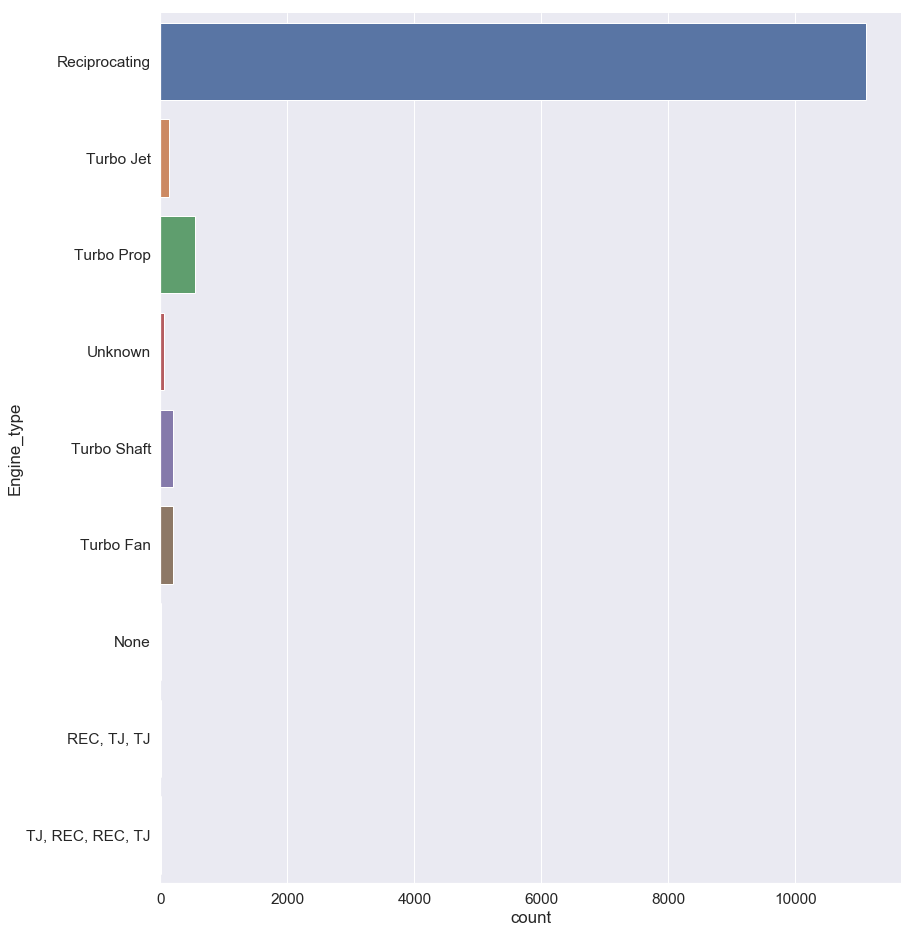

In [38]:
#Distribution for Engine type
sb.catplot(y = "Engine_type", data = clean_df, kind = "count", height = 13)

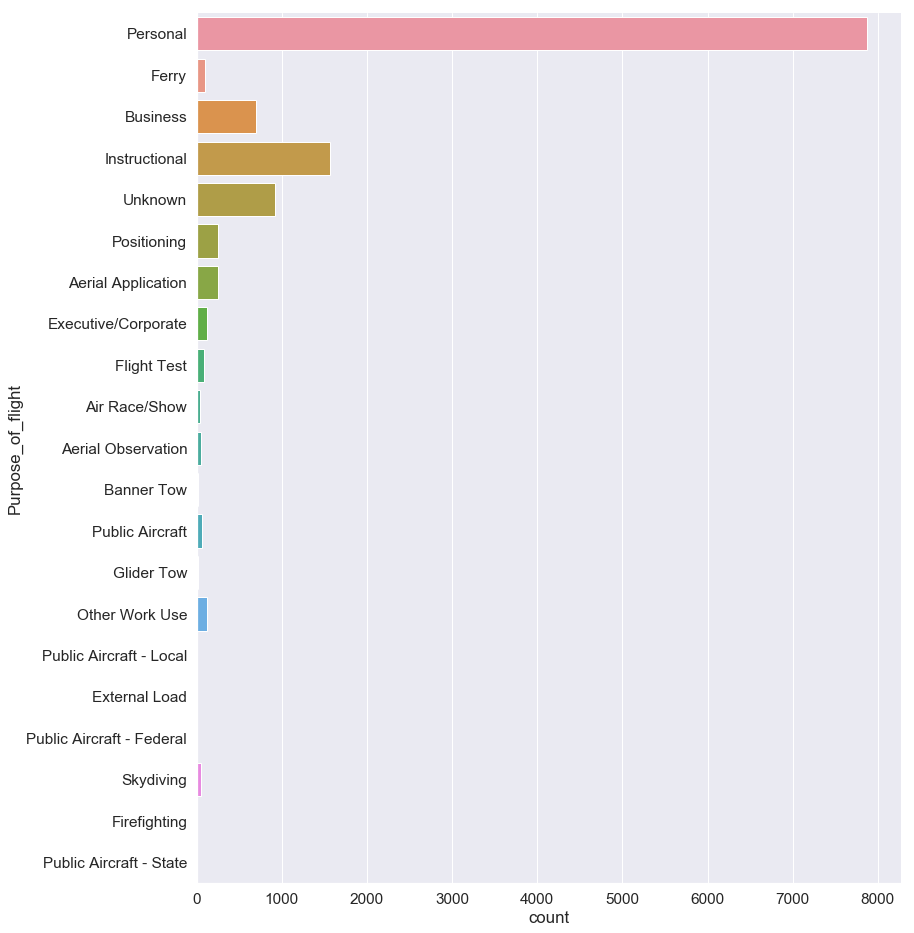

In [39]:
#Distribution for Purpose of flight
sb.catplot(y = "Purpose_of_flight", data = clean_df, kind = "count", height = 13)

#Bi-variate Exploratory Analysis

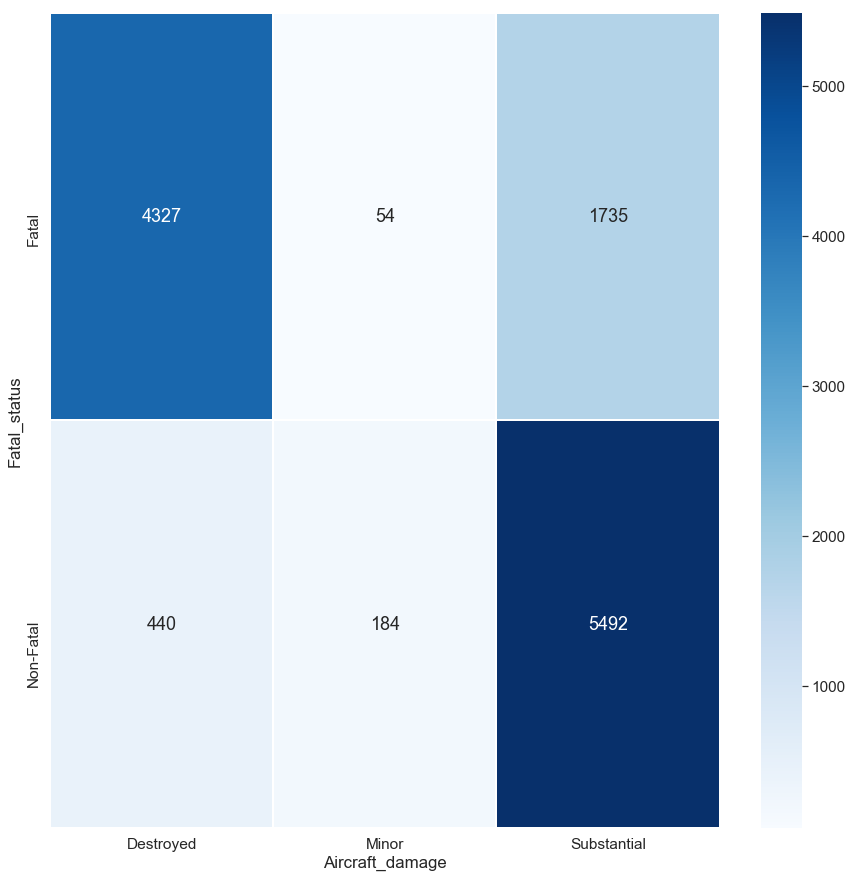

In [40]:
# Distribution of the two variables (Fatal Status and Aircraft Damage)
f, axes = plt.subplots(1, 1, figsize=(15, 15))
sb.heatmap(clean_df.groupby(['Fatal_status', 'Aircraft_damage']).size().unstack(), 
           linewidths = 1, annot = True, fmt='g', annot_kws = {"size": 18}, cmap = "Blues")

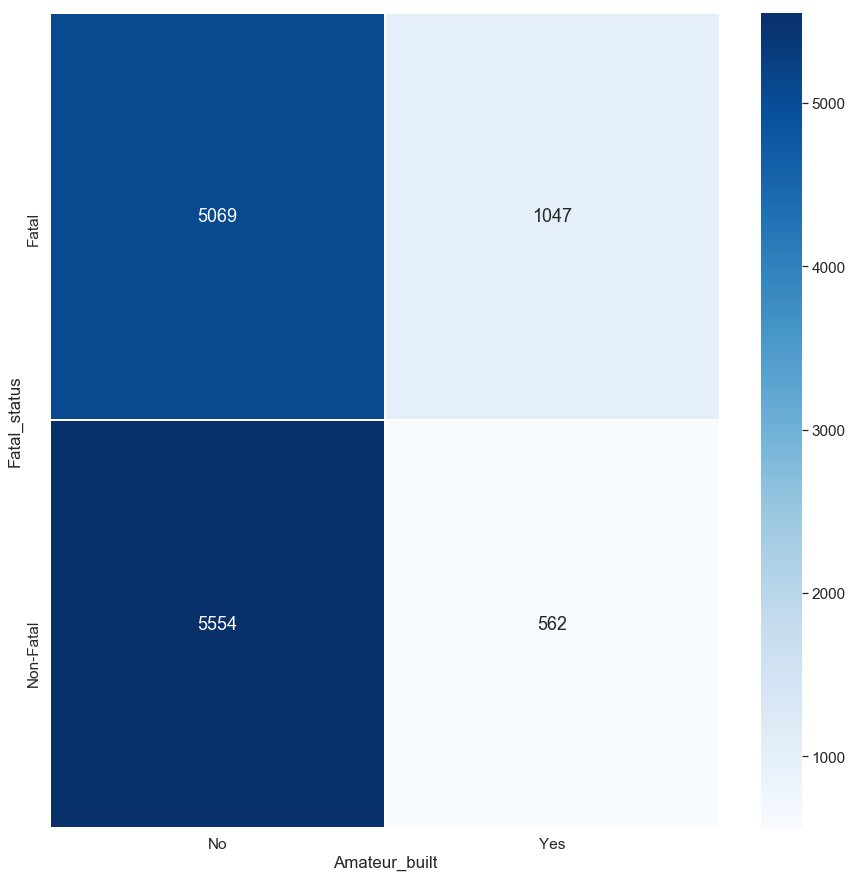

In [41]:
# Distribution of the two variables (Amateur built and Fatal Status)
f, axes = plt.subplots(1, 1, figsize=(15, 15))
sb.heatmap(clean_df.groupby(['Fatal_status', 'Amateur_built']).size().unstack(), 
           linewidths = 1, annot = True, fmt='g', annot_kws = {"size": 18}, cmap = "Blues")

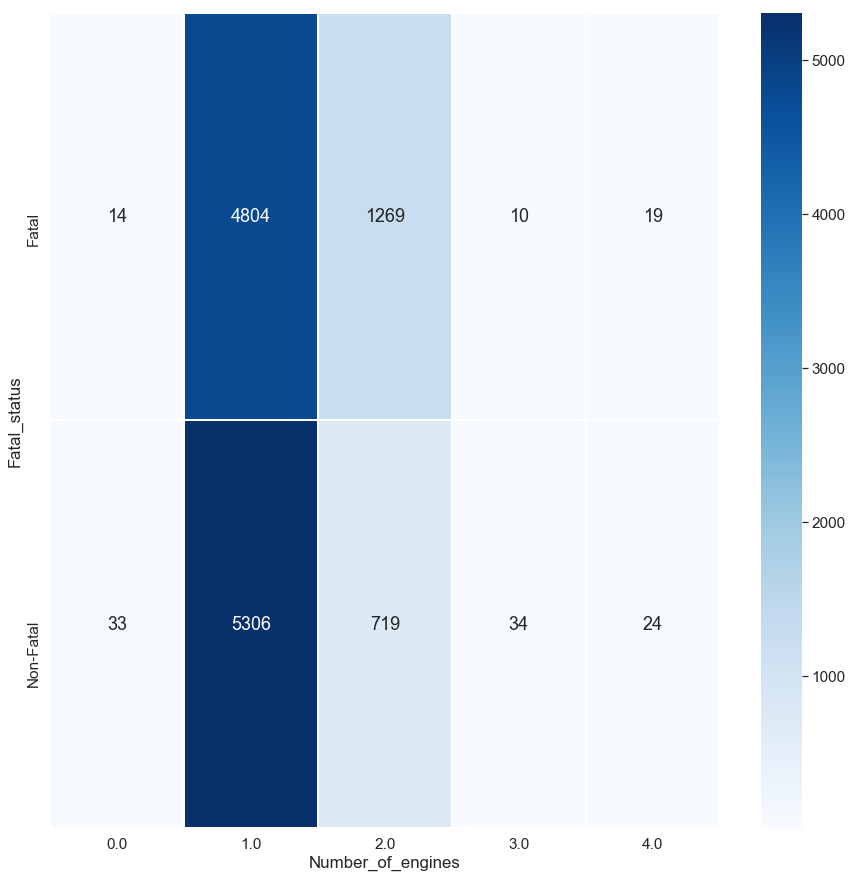

In [42]:
# Distribution of the two variables (Number of Egnines and Fatal Status)
f, axes = plt.subplots(1, 1, figsize=(15, 15))
sb.heatmap(clean_df.groupby(['Fatal_status', 'Number_of_engines']).size().unstack(), 
           linewidths = 1, annot = True, fmt='g', annot_kws = {"size": 18}, cmap = "Blues")

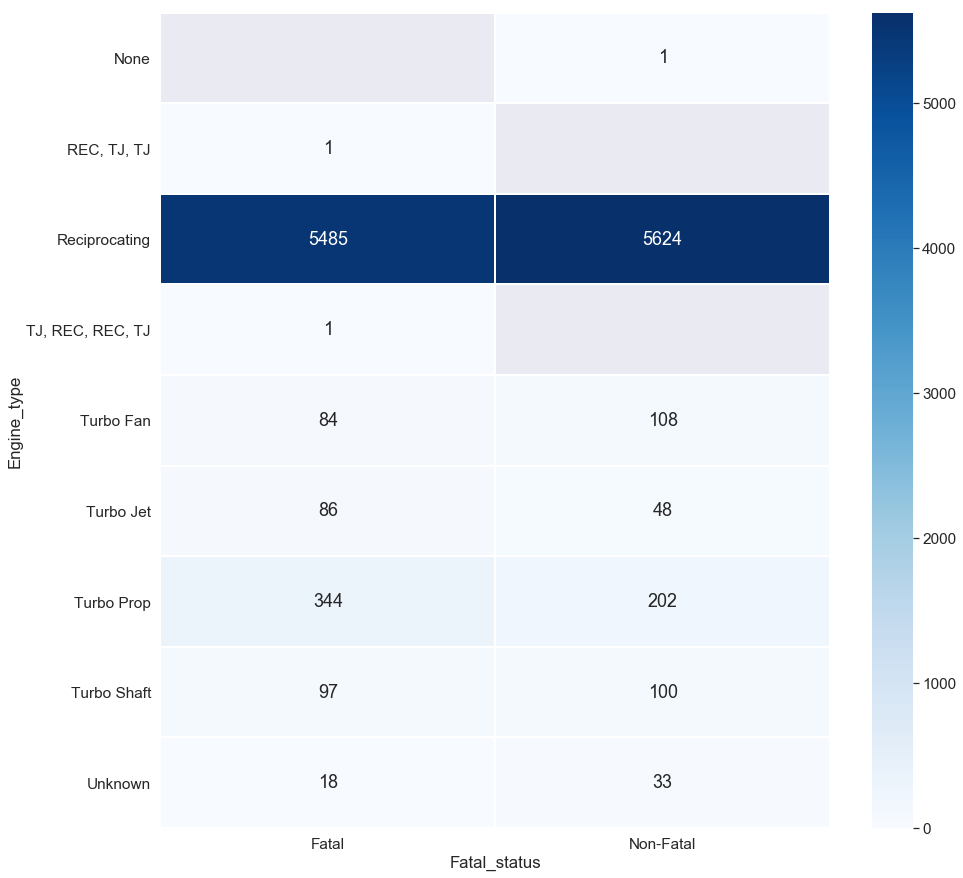

In [43]:
# Distribution of the two variables (Engine Type and Fatal Status)
f, axes = plt.subplots(1, 1, figsize=(15, 15))
sb.heatmap(clean_df.groupby(['Engine_type', 'Fatal_status']).size().unstack(), 
           linewidths = 1, annot = True, fmt='g', annot_kws = {"size": 18}, cmap = "Blues")

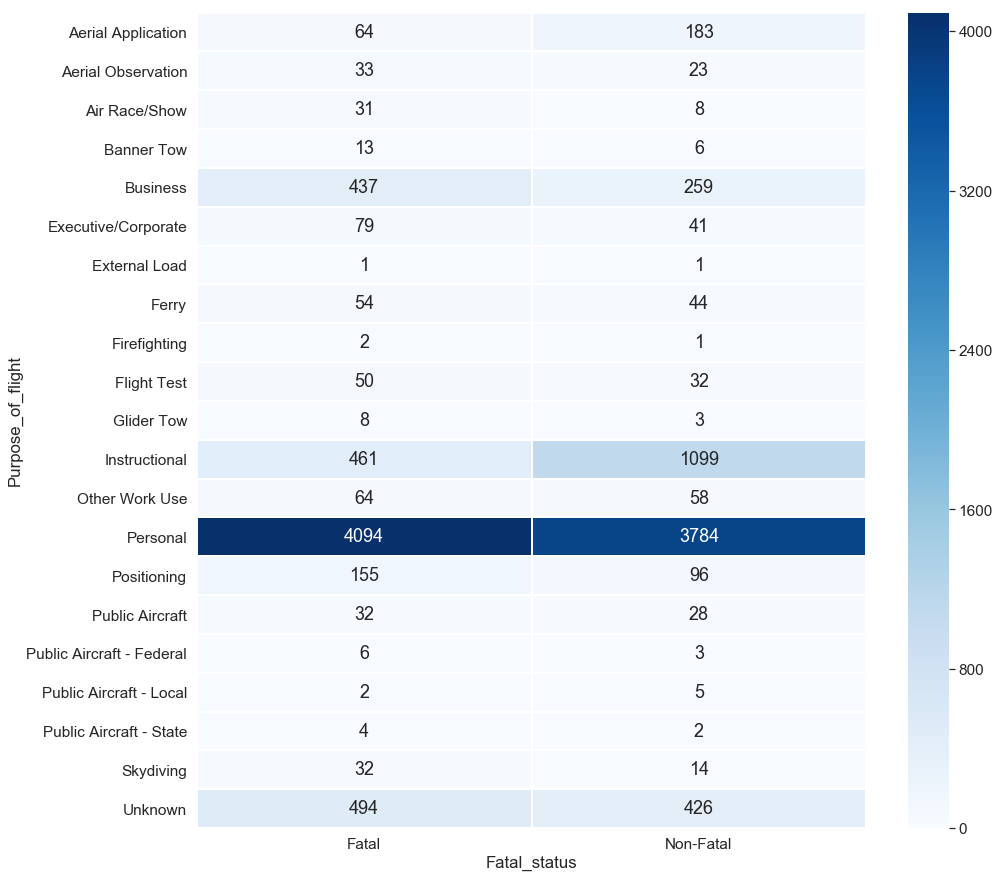

In [44]:
# Distribution of the two variables (Purpose of Flight and Fatal Status)
f, axes = plt.subplots(1, 1, figsize=(15, 15))
sb.heatmap(clean_df.groupby(['Purpose_of_flight', 'Fatal_status']).size().unstack(), 
           linewidths = 1, annot = True, fmt='g', annot_kws = {"size": 18}, cmap = "Blues")

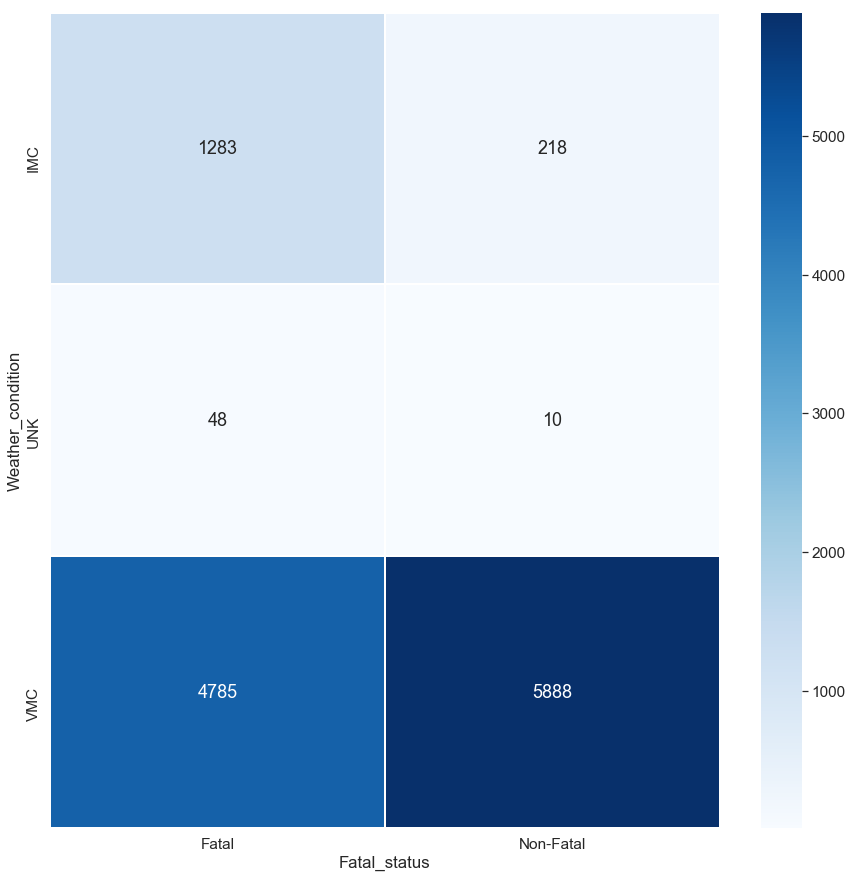

In [45]:
# Distribution of the two variables (Weather Condition and Fatal Status)
f, axes = plt.subplots(1, 1, figsize=(15, 15))
sb.heatmap(clean_df.groupby(['Weather_condition', 'Fatal_status']).size().unstack(), 
           linewidths = 1, annot = True, fmt='g', annot_kws = {"size": 18}, cmap = "Blues")

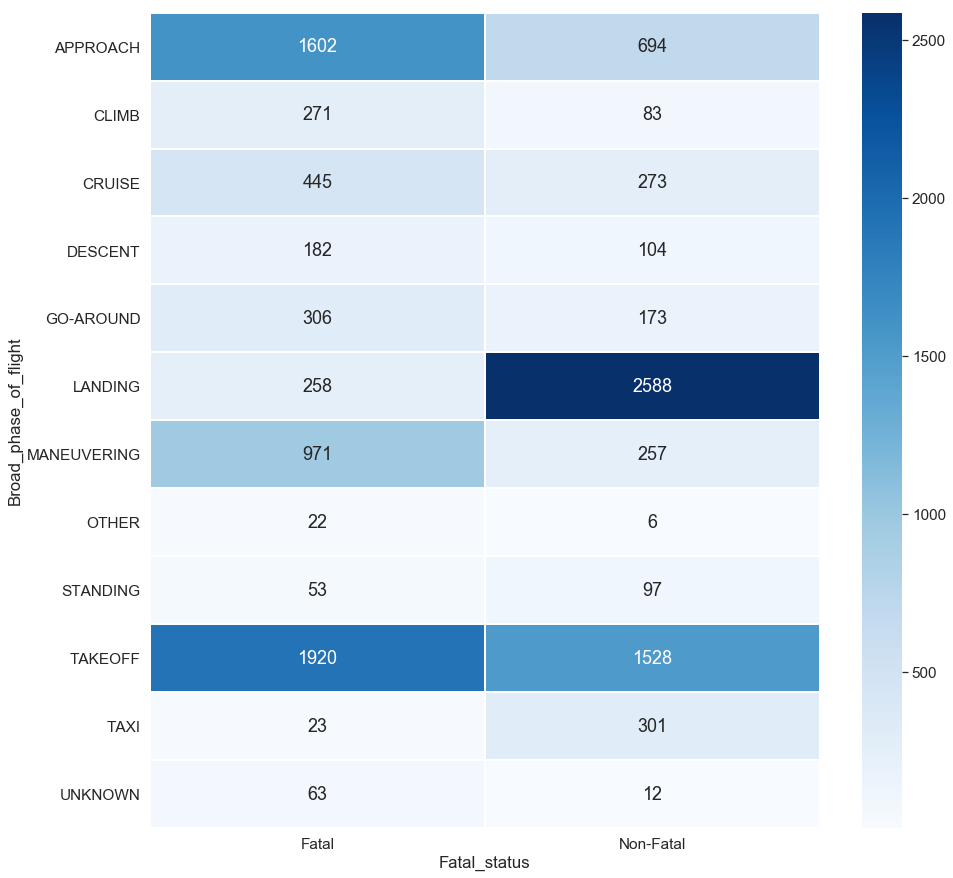

In [46]:
# Distribution of the two variables (Broad Phase of Flight and Fatal Status)
f, axes = plt.subplots(1, 1, figsize=(15, 15))
sb.heatmap(clean_df.groupby(['Broad_phase_of_flight', 'Fatal_status']).size().unstack(), 
           linewidths = 1, annot = True, fmt='g', annot_kws = {"size": 18}, cmap = "Blues")

#Classification Analysis

###Decision Tree Analysis

Some of the significant risk factors include weather conditions, phase of flight, and aircraft damage. We will investigate on these factors and use the results to give advisories for future flights.

The first factor to analyse is weather condition. We will start by setting up a simple Classification Problem. 

Response Variable: Fatal_status       
Predictor = Weather.condition

In [47]:
print("Data type : ", type(clean_df))
print("Data dims : ", clean_df.shape)
fatal = pd.DataFrame(clean_df['Fatal_status']) 
weather = pd.DataFrame(clean_df['Weather_condition'])


Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (12232, 32)


Set up the classification problem with Train and Test datasets. 
Train set with 52943 samples and Test set with 17647 samples

In [48]:
import math
data_total = len(weather)
train_total = math.ceil(data_total*0.75)
test_total = math.floor(data_total*0.25)*-1

# Train Set : 52943 samples
weather_train = pd.DataFrame(weather[:train_total])
fatal_status_train = pd.DataFrame(fatal[:train_total])

# Test Set : 17647 samples
weather_test = pd.DataFrame(weather[test_total:])
fatal_status_test = pd.DataFrame(fatal[test_total:])

# Check the sample sizes
print("Train Set :", fatal_status_train.shape, weather_train.shape)
print("Test Set  :", fatal_status_test.shape, weather_test.shape)

type(fatal_status_train["Fatal_status"])

Train Set : (9174, 1) (9174, 1)
Test Set  : (3058, 1) (3058, 1)


pandas.core.series.Series

Basic statistical exploration and vizualization on the Train set

In [49]:
# Summary Statistics for Fatal Status Train
fatal_status_train["Fatal_status"].value_counts()


Non-Fatal    6116
Fatal        3058
Name: Fatal_status, dtype: int64

In [50]:

# Summary Statistics for Weather Train
weather_train.describe()

,Weather_condition
count,9174
unique,3
top,VMC
freq,8411


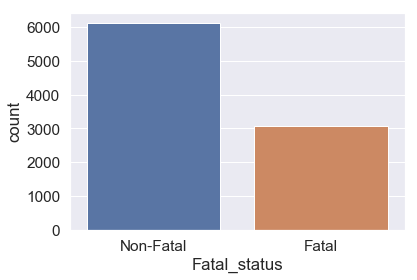

In [51]:
# Count Plot for Fatal Status Train
sb.countplot(fatal_status_train["Fatal_status"])

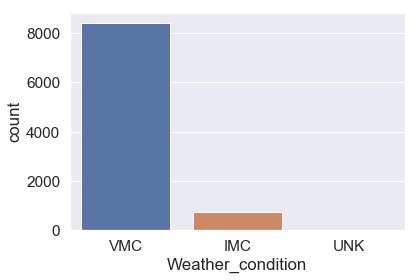

In [52]:
# Count Plot for Weather Train
sb.countplot(weather_train["Weather_condition"])

In [53]:
weather_train.Weather_condition.astype("category").cat.codes
cleanup_nums = {"Weather_condition": {"VMC": 2, "IMC": 1, "UNK":0}}
weather_train.replace(cleanup_nums, inplace=True)
weather_train.head()

,Weather_condition
0,2
1,2
2,2
3,2
4,2


In [54]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 2)

# Train the Decision Tree Classifier model
dectree.fit(weather_train, fatal_status_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [55]:
# Import export_graphviz from sklearn.tree
from sklearn.tree import export_graphviz

# Export the Decision Tree as a dot object
treedot = export_graphviz(dectree,                                      # the model
                          feature_names = weather_train.columns,          # the features 
                          out_file = None,                              # output file
                          filled = True,                                # node colors
                          rounded = True,                               # make pretty
                          special_characters = True)                    # postscript

# Render using graphviz
import graphviz
graphviz.Source(treedot)

ModuleNotFoundError: No module named 'graphviz'

#Bi-variate analysis

weather_df = pd.DataFrame(

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Multi-variate Decision tree with get_dummies

In [ ]:

x = pd.DataFrame(clean_df[['Make', 
                           'Model', 
                           'Amateur_built', 
                           'Engine_type', 
                           'Weather_condition', 
                           'Broad_phase_of_flight'
                           ]])
x.info()

In [ ]:
x = pd.get_dummies(x, prefix_sep='_', drop_first=True)
y = clean_df['Fatal_status'].copy()
y = y.astype('category')
y.head()

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
f, axes = plt.subplots(1, 1, figsize=(12, 8))
sb.countplot(y_train)

In [ ]:
# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  
dectree.fit(x_train, y_train)                   
# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(x_train)
y_test_pred = dectree.predict(x_test)

In [ ]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(x_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(x_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(2, 1, figsize=(12, 24))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [ ]:
treedot = export_graphviz(dectree,                                      # the model
                          feature_names = x_train.columns,              # the features 
                          out_file = None,                              # output file
                          filled = True,                                # node colors
                          rounded = True,                               # make pretty
                          special_characters = True)                    # postscript

graphviz.Source(treedot)

In [ ]:
# Extract random 5 data from test to visualise Prediction
data_pred = x_test.sample(n = 15)
data_pred

data_pred_index = list(data_pred.index.values)

data_pred_items = clean_df.loc[ data_pred_index ,['Make', 'Model', 'Amateur_built', 'Engine_type', 'Purpose_of_flight', 'Weather_condition', 'Broad_phase_of_flight', 'Fatal_status'] ]
data_pred_items

In [ ]:
# Extract Predictors for Prediction
x_pred = pd.DataFrame(data_pred)

# Predict Response corresponding to Predictors
y_pred = dectree.predict(x_pred)
y_pred

In [ ]:
# Summarize the Actuals and Predictions
y_pred = pd.DataFrame(y_pred, columns = ["Pred_Stat"], index = data_pred.index)
#data_acc = pd.concat(

data_acc = pd.concat([data_pred_items, y_pred], axis = 1)

data_acc

In [ ]:
y_prob = dectree.predict_proba(x_pred)
np.set_printoptions(precision = 3)
print(y_prob)

###Bi Variate Analysis

In [ ]:
from sklearn import metrics
logreg = LogisticRegression()

logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_percentage = 100 * accuracy
accuracy_percentage

###K-Means Clustering

#Additional Analysis

###Map of Accidents

In [ ]:
map_data.head()

In [ ]:
##need to clean up data to remove null values and empty values, else map cannot display
##map_data = aData[['year', 'month', 'Map_latitude', 'Map_longitude', 'Aircraft.Damage', 'Fatal_status', 'Location']]
map_ = folium.Map(location =[40,-90], tiles="OpenStreetMap" , zoom_start = 2)

for i in range(0,len(map_data)):
  if map_data.iloc[i]['Fatal_status'] == "Fatal":
    folium.Marker([map_data.iloc[i]['Map_latitude'], map_data.iloc[i]['Map_longitude']], popup=str(map_data.iloc[i]['Location'])).add_to(map_)

map_

###Which purpose of flight has the most casualties?

In [ ]:

inj_cols = ['Total_fatal_injuries', 'Total_serious_injuries', 'Total_minor_injuries', 'Total_uninjured']

inj_per_occ = clean_df.groupby('Purpose_of_flight')[inj_cols].sum()
inj_per_occ['Total_injured'] = inj_per_occ['Total_serious_injuries'] + inj_per_occ['Total_minor_injuries'] + inj_per_occ['Total_fatal_injuries']
inj_per_occ

In [ ]:
inj_per_occ.loc[inj_per_occ.index[:22], ['Total_injured', 'Total_uninjured']].plot.barh(stacked=True);

###What happens to people?

In [ ]:
injury_types = ['Total_fatal_injuries', 'Total_serious_injuries', 'Total_minor_injuries', 'Total_uninjured']
injuries_per_phase = clean_df[injury_types + ['Broad_phase_of_flight']].groupby('Broad_phase_of_flight').sum()
injuries_per_phase = injuries_per_phase.iloc[:10]
injuries_per_phase['Total_injuried'] = injuries_per_phase['Total_serious_injuries'] + injuries_per_phase['Total_fatal_injuries'] + injuries_per_phase['Total_minor_injuries']
injuries_per_phase['Total_serious_minor_injured'] = injuries_per_phase['Total_serious_injuries'] + injuries_per_phase['Total_minor_injuries']
injuries_per_phase

In [ ]:
injuries_per_phase[['Total_injuried', 'Total_uninjured']].plot.barh();

In [ ]:
injuries_per_phase[['Total_fatal_injuries', 'Total_serious_minor_injured']].plot.barh();

###Airport Hotspots

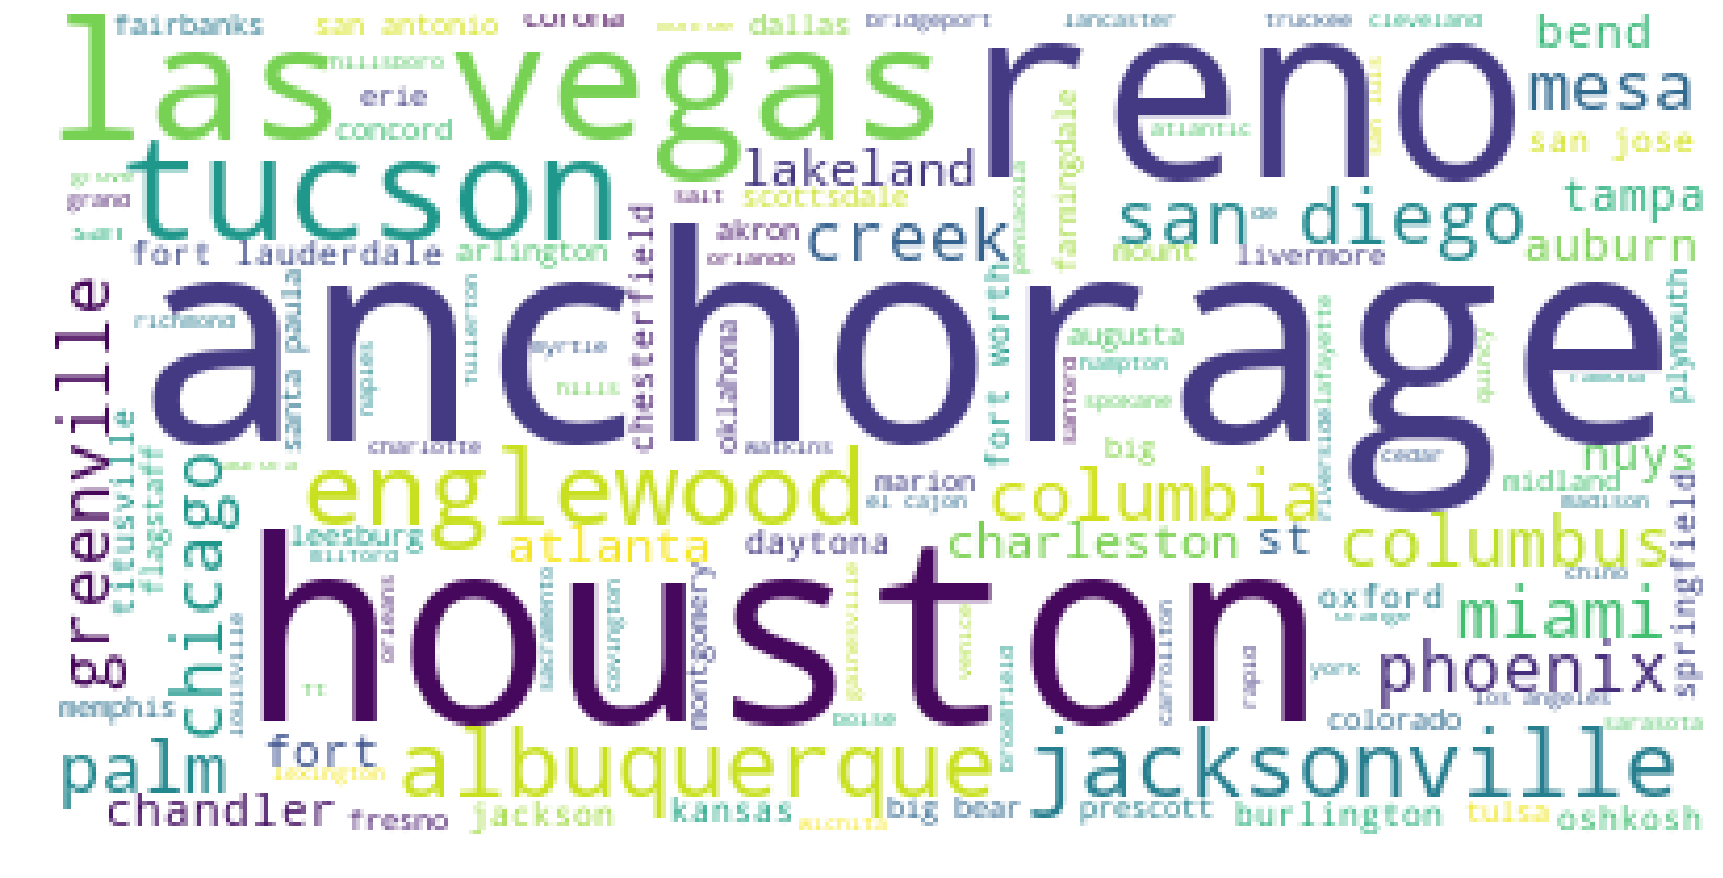

In [56]:
all_location = ' '.join(clean_df['Location'].str.lower())
stopwords = STOPWORDS
stopwords.update(['ca', 'tx', 'il', 'fl', 'mi', 'ny', 'pa', 'nc', 'oh', 'tn', 'ak', 'mn', 'ne', 'wl', 'ma', 'ga', 'wa', 'wi', 'ar', 'va', 'al', 'co', 'nj', 'az', 'ks', 'la', 'ia', 'mo', 'ok', 'mt', 'nm', 'ky', 'md', 'id', 'sc', 'ms', 'nd', 'ut', 'nv', 'ct', 'wv', 'city', 'lake', 'fall', 'island', 'hill', 'new', 'spring', 'falls', 'nh', 'west', 'valley', 'sd', 'bay', 'beach', 'wy', 'vt', 'springs', 'port', 'boulder', 'long', 'north', 'rock', 'van', 'little', 'river', 'east', 'point', 'hi'])


wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=500).generate(all_location)
rcParams['figure.figsize'] = 30, 40
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

###K Cluster

In [57]:
drop = ['Event_id', 'Event_date', 'Location', 'Country', 'Latitude', 'Longitude', 'Airport_code', 'Airport_name', 'month', 'day', 'year', 'Map_latitude', 'Map_longitude', 'Make', 'Model']
data = pd.DataFrame(clean_df)
data.drop(columns=drop, inplace=True)
data.head()


categorical_features = ['Investigation_type', 'Injury_severity', 'Aircraft_damage', 'Aircraft_category', 'Amateur_built', 'Number_of_engines', 'Engine_type', 'Purpose_of_flight', 'Weather_condition', 'Broad_phase_of_flight', 'Fatal_status']
continuous_features = ['Total_fatal_injuries', 'Total_serious_injuries', 'Total_minor_injuries', 'Total_uninjured', 'Deaths', 'Total_passengers']
data[continuous_features].describe()

,Total_fatal_injuries,Total_serious_injuries,Total_minor_injuries,Total_uninjured,Deaths,Total_passengers
count,12232.000000,12232.000000,12232.000000,12232.000000,12232.000000,12232.000000
mean,1.035889,0.225638,0.249673,1.774035,1.035889,3.285235
std,3.735701,1.360384,1.819181,13.262984,3.735701,14.538725
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.500000,0.000000,0.000000,0.000000,0.500000,2.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000
max,228.000000,81.000000,125.000000,371.000000,228.000000,411.000000


In [58]:
for col in categorical_features:
    dummies = pd.get_dummies(data[col], prefix=col)
    data = pd.concat([data, dummies], axis=1)
    data.drop(col, axis=1, inplace=True)
data.head()


,Total_fatal_injuries,Total_serious_injuries,Total_minor_injuries,Total_uninjured,Deaths,Total_passengers,Investigation_type_Accident,Investigation_type_Incident,Injury_severity_Fatal(1),Injury_severity_Fatal(10),...,Broad_phase_of_flight_GO-AROUND,Broad_phase_of_flight_LANDING,Broad_phase_of_flight_MANEUVERING,Broad_phase_of_flight_OTHER,Broad_phase_of_flight_STANDING,Broad_phase_of_flight_TAKEOFF,Broad_phase_of_flight_TAXI,Broad_phase_of_flight_UNKNOWN,Fatal_status_Fatal,Fatal_status_Non-Fatal
0,0.0,0.0,0.0,3.0,0,3.0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0.0,0.0,1.0,0.0,0,1.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0.0,0.0,1.0,0.0,0,1.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.0,0.0,1.0,2.0,0,3.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0.0,0.0,0.0,1.0,0,1.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [59]:
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)

/Users/bryan123bryan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [60]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

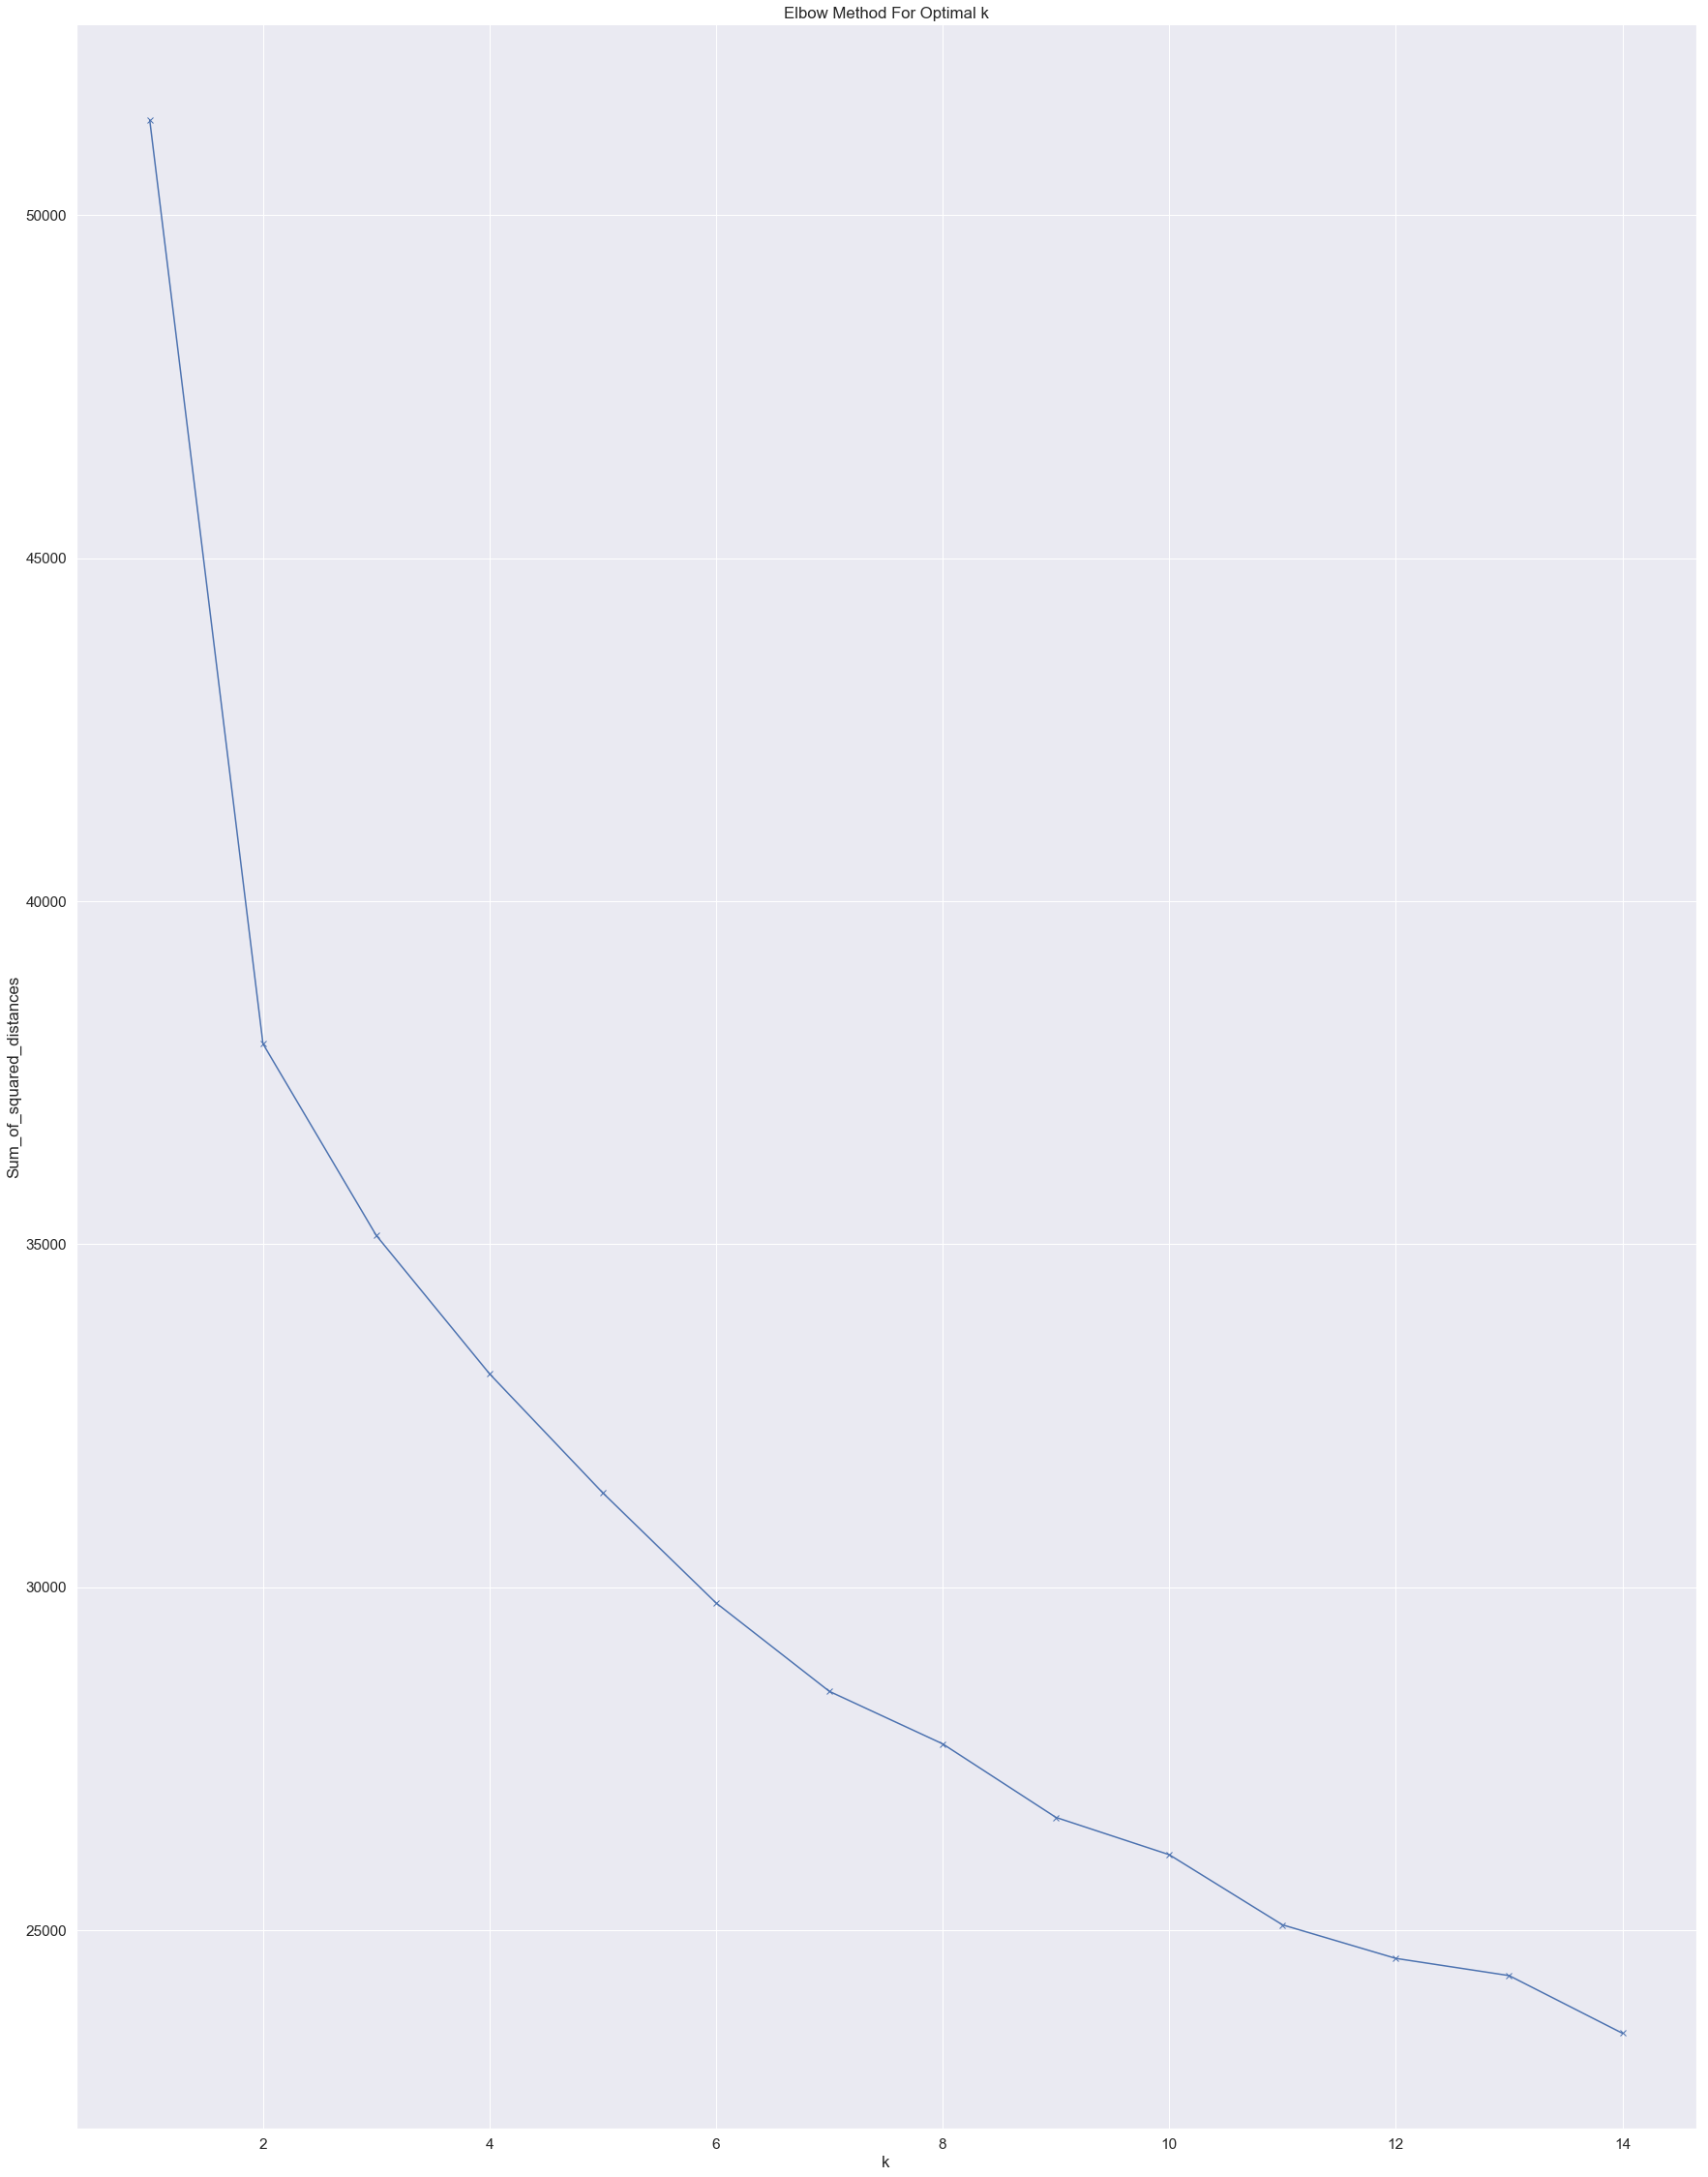

In [66]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [67]:
drop = ['Event_id', 'Event_date', 'Location', 'Country', 'Latitude', 'Longitude', 'Airport_code', 'Airport_name', 'month', 'day', 'year', 'Map_latitude', 'Map_longitude', 'Make', 'Model']
data = pd.DataFrame(clean_df)
data.drop(columns=drop, inplace=True)
data.head()


categorical_features = ['Investigation_type', 'Injury_severity', 'Aircraft_damage', 'Aircraft_category', 'Amateur_built', 'Number_of_engines', 'Engine_type', 'Purpose_of_flight', 'Weather_condition', 'Broad_phase_of_flight', 'Fatal_status']
continuous_features = ['Total_fatal_injuries', 'Total_serious_injuries', 'Total_minor_injuries', 'Total_uninjured', 'Deaths', 'Total_passengers']
data_transformed = data[categorical_features]

In [68]:
# Set "optimal" Clustering Parameters
num_clust = 6
init_algo = 'k-means++'

# Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust,         
               init = init_algo,
               n_init = 20)                 

# Fit the Clustering Model on the Data
kmeans.fit(data_transformed)

ValueError: could not convert string to float: 'Fatal'

In [ ]:
# Print the Cluster Centers
print("Features", "\tInvestigation_type", "\tInjury_severity", "\tAircraft_damage", "\tAircraft_category", "\tAmateur_built", "\tNumber_of_engines", "\tEngine_type", "\tPurpose_of_flight", "\tWeather_condition", "\tBroad_phase_of_flight", "\tFatal_status")
print()

for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t")
    print()
print()

# Print the Within Cluster Sum of Squares
print("Within Cluster Sum of Squares :", kmeans.inertia_)
print()

# Predict the Cluster Labels
labels = kmeans.predict(data_transformed)

# Append Labels to the Data
data_transformed_labeled = data_transformed.copy()
data_transformed_labeled["Cluster"] = pd.Categorical(labels)

# Summary of the Cluster Labels
sb.countplot(data_transformed_labeled["Cluster"])

In [ ]:
# Average Behaviour of each Cluster
cluster_data = pd.DataFrame(data_transformed_labeled.groupby(by = "Cluster").mean())
cluster_data.plot.bar(figsize = (16,6))

In [70]:
pip install catboost
install.packages('devtools')
devtools::install_github('catboost/catboost', subdir = 'catboost/R-package')

SyntaxError: invalid syntax (<ipython-input-70-0a6612709e0b>, line 1)